In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [59]:
import pystan, GPy, scipy, stan_utility

# Example: one-way hierarchical model 

## centered model 

In [219]:
code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma;
}
parameters {
    real mu;
    real<lower=0> tau;
    real theta[J];
}
model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 2.5);
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""

code = """
data {
    int<lower=0> N;
    int<lower=1> G;
    real y[N];
    int<lower=1, upper=G> group[N];
    real<lower=0> sigma;
}
parameters {
    real mu;
    real<lower=0> tau;
    real theta[G];
}
transformed parameters{
    real yhat[N];
    
    for(i in 1:N)
        yhat[i] = theta[group[i]];
}
model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 2.5);
    theta ~ normal(mu, tau);
    y ~ normal(yhat, sigma);        
}
"""

model = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b3c4120f866dbd0960a54c06cecc68f NOW.


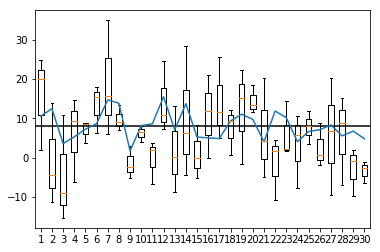

In [232]:
mu = 8.
tau = 3.
ysigma=10
n = 10
g = 30
nrep = 3

# theta = scipy.stats.norm.rvs(mu, scale=tau, size=n)
# y = scipy.stats.norm.rvs(theta, scale=ysigma)

theta = scipy.stats.norm.rvs(mu, scale=tau, size=g)
y = scipy.stats.norm.rvs(np.repeat(theta, nrep), scale=ysigma)


plt.axhline(mu, c='k')

#plt.plot(theta)
# plt.plot(np.repeat(theta, nrep))
# plt.plot(y)

plt.boxplot([y[i*nrep:(i+1)*nrep] for i in range(g)])
plt.plot(range(1, g+1), theta)

In [233]:
# config = {
#     'J': n,
#     'y': y,
#     'sigma': ysigma
# }

config = {
    'N': g*nrep,
    'G': g,
    'group': np.repeat(1+np.arange(g), nrep),
    'y': y,
    'sigma': ysigma
}

samples = model.sampling(data=config, chains=4, iter=2000)
samples

Inference for Stan model: anon_model_1b3c4120f866dbd0960a54c06cecc68f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          5.71    0.09   1.11   3.65   4.99   5.69   6.45   7.99  159.0   1.03
tau         1.99    0.18   1.29   0.29   0.96   1.72   2.81   4.99   50.0   1.07
theta[0]    6.92    0.17   2.57   2.89   5.17   6.49   8.22  13.19  222.0   1.02
theta[1]    4.92    0.09   2.27  -0.46   3.85   5.08    6.3   8.98  659.0   1.01
theta[2]    4.44    0.11    2.5  -1.61   3.36   4.77   5.97   8.36  475.0   1.01
theta[3]    5.77    0.07   2.19   1.28   4.48   5.67   7.03  10.34  946.0   1.01
theta[4]    5.91    0.04   2.28   1.47   4.53   5.75   7.22  10.97 4000.0   1.01
theta[5]    6.63    0.14    2.4   2.74   4.98   6.33   7.89  12.38  290.0   1.02
theta[6]    7.31    0.23    2.9   3.19   5.34   6.77   8.63  14.73  164.0   1.02
t

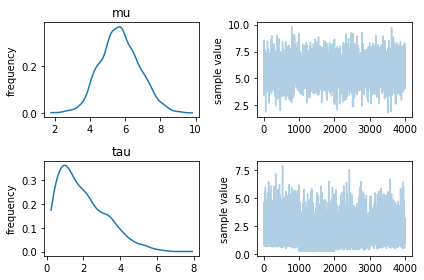

In [234]:
samples.plot(['mu', 'tau']);
plt.tight_layout()

In [235]:
stan_utility.check_treedepth(samples)

0 of 4000 iterations saturated the maximum tree depth of 10 (0%)


In [236]:
stan_utility.check_div(samples)

116.0 of 4000 iterations ended with a divergence (2.9%)
Try running with larger adapt_delta to remove the divergences


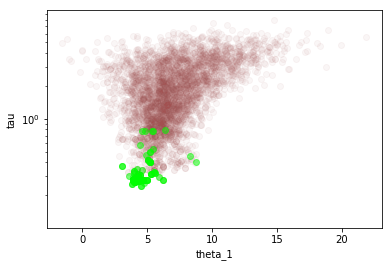

In [237]:
nondiv_params, div_params = stan_utility.partition_div(samples)

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

plt.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.05)
plt.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plt.semilogy()

plt.xlabel('theta_1')
plt.ylabel('tau')

In [238]:
samp = samples.extract()
samp

OrderedDict([(u'mu',
              array([ 6.42795734,  3.44685943,  6.41218909, ...,  5.27414174,
                      5.70672168,  5.77495939])),
             (u'tau',
              array([ 2.18294646,  1.54437189,  1.87700009, ...,  2.68359684,
                      2.80186867,  2.74533077])),
             (u'theta',
              array([[ 8.61927488,  5.2194834 ,  5.74261099, ...,  7.56547561,
                       6.63129543,  1.6281565 ],
                     [ 7.56314754,  1.7429455 ,  2.94655848, ...,  5.54023328,
                       5.96540487,  3.22052467],
                     [ 8.28611477,  7.67794047,  3.31516833, ...,  9.83003984,
                       6.51666499,  5.32665828],
                     ..., 
                     [ 6.78369439,  5.31756261,  6.45144817, ...,  7.05294434,
                       3.52547998,  0.57703281],
                     [ 9.30095371,  5.15067529,  7.19401749, ...,  3.15475581,
                       3.77796842,  7.82040363],
          

In [239]:
samp['mu'].shape

(4000,)

In [240]:
samp['tau'].shape

(4000,)

In [241]:
samp['theta'].shape

(4000, 30)

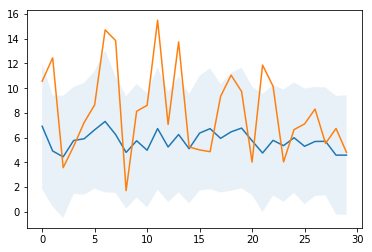

In [242]:
plt.plot(samp['theta'].mean(0))
plt.fill_between(range(g), 
                 samp['theta'].mean(0) - 1.98*samp['theta'].std(0), 
                 samp['theta'].mean(0) + 1.98*samp['theta'].std(0),
                alpha=.1)

plt.plot(theta)

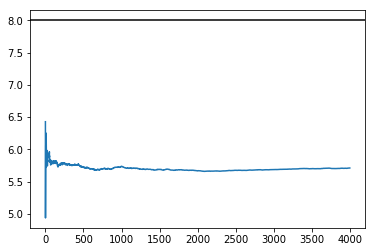

In [243]:
plt.plot(np.cumsum(samp['mu'])/(1.+np.arange(4000)))
plt.axhline(mu, color='k')

## non-centered model 

In [245]:
code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma;
}
parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}
transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

code = """
data {
    int<lower=0> N;
    int<lower=1> G;
    real y[N];
    int<lower=1, upper=G> group[N];
    real<lower=0> sigma;
}
parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[G];
}
transformed parameters{
    real yhat[N];
    real theta[G];
    
    for (j in 1:G)
        theta[j] = mu + tau * theta_tilde[j];
    
    for(i in 1:N)
        yhat[i] = theta[group[i]];
}
model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 2.5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(yhat, sigma);        
}
"""

model_nc = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d7c07a87ea244c8ae619107d225a4c6 NOW.


In [247]:
# config = {
#     'J': n,
#     'y': y,
#     'sigma': ysigma
# }

config = {
    'N': g*nrep,
    'G': g,
    'group': np.repeat(1+np.arange(g), nrep),
    'y': y,
    'sigma': ysigma
}

samples = model_nc.sampling(data=config, chains=4, iter=2000)
samp = samples.extract()

In [248]:
samples

Inference for Stan model: anon_model_1d7c07a87ea244c8ae619107d225a4c6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                5.85    0.02   1.11   3.63   5.09   5.88   6.61   8.02 4000.0    1.0
tau               1.86    0.03   1.33   0.09   0.78   1.63    2.7   4.94 1907.0    1.0
theta_tilde[0]    0.43    0.02   0.98  -1.49  -0.25   0.43   1.11   2.29 4000.0    1.0
theta_tilde[1]   -0.29    0.02   0.97  -2.17  -0.94   -0.3   0.36   1.66 4000.0    1.0
theta_tilde[2]   -0.46    0.01   0.94  -2.27  -1.09  -0.49   0.19   1.46 4000.0    1.0
theta_tilde[3]  9.7e-4    0.01   0.92  -1.78  -0.62-1.4e-3   0.63   1.75 4000.0    1.0
theta_tilde[4]    0.03    0.02   0.98  -1.91  -0.63   0.03   0.68   1.97 4000.0    1.0
theta_tilde[5]    0.35    0.02   0.95  -1.54   -0.3   0.36   1.01   2.15 4000.0    1.0
theta_tilde[6]    0.59    0.

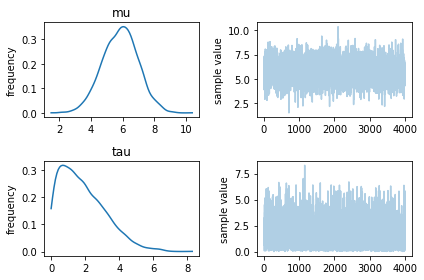

In [249]:
samples.plot(['mu', 'tau']);
plt.tight_layout()

In [250]:
stan_utility.check_treedepth(samples)

0 of 4000 iterations saturated the maximum tree depth of 10 (0%)


In [251]:
stan_utility.check_div(samples)

0.0 of 4000 iterations ended with a divergence (0.0%)


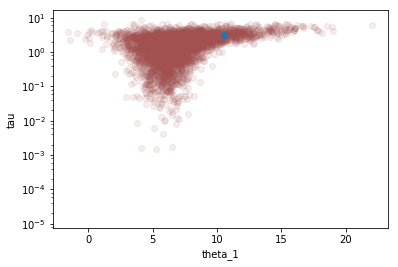

In [258]:
nondiv_params, div_params = stan_utility.partition_div(samples)

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

plt.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plt.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.1)


plt.semilogy()

plt.scatter(theta[0], tau)

plt.xlabel('theta_1')
plt.ylabel('tau')


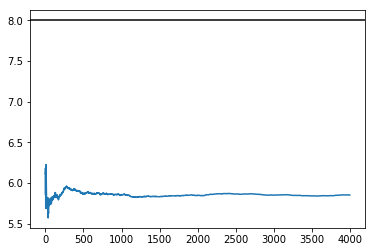

In [253]:
plt.plot(np.cumsum(samp['mu'])/(1.+np.arange(4000)))
plt.axhline(mu, color='k')

# GP model 

In [ ]:
def plotFunctionSamples(param, plotKwargs={}, fillKwargs={}, **kwargs):
    plotKwargs.update(kwargs)
    fillKwargs.update(kwargs)
    
    plt.plot(x, param.mean(0), **plotKwargs)
    plt.fill_between(x, param.mean(0)-1.98*param.std(0), param.mean(0)+1.98*param.std(0), alpha=.1, **fillKwargs)

In [ ]:
code = """
data {
  int<lower=1> N;
  vector[N] y;
  real x[N];
}
parameters {
  //constrain hyperparameters to be positive
  real<lower=0> length_scale;
  real<lower=0> alpha;
  real<lower=0> sigma;
  vector[N] f_eta;
}
transformed parameters {
  vector[N] f;
  {
    // define unneeded variables inside brackets 
    // to prevent storage by sampler
    matrix[N, N] L_cov;
    matrix[N, N] cov;
    cov = cov_exp_quad(x, alpha, length_scale);
    for (n in 1:N)
      cov[n, n] = cov[n, n] + 1e-12;
    L_cov = cholesky_decompose(cov);
    f = L_cov * f_eta;
  }
}
model {
  length_scale ~ gamma(2, 2);
  alpha ~ normal(0, 1);
  sigma ~ normal(0, 1);
  f_eta ~ normal(0, 1);
  y ~ normal(f, sigma);
}
"""

model = pystan.StanModel(model_code=code)

In [ ]:
n = 20
x = np.linspace(-1,1,n)
k = GPy.kern.RBF(1)

cov = np.tile(k.K(x[:,None]), (2,2))
cov[:n, :n] += .1 * np.eye(n)

s = scipy.stats.multivariate_normal.rvs(np.zeros(2*n), cov)
y, f = s[:n], s[n:]

plt.plot(x, f)
plt.scatter(x, y)

In [ ]:
cfg = {
    'N': n,
    'y': y,
    'x': x
}

samples = model.sampling(data=cfg, iter=2000)
samples

In [ ]:
samp = samples.extract()

In [ ]:
samp.keys()

In [ ]:
plt.plot(x, samp['f'].mean(0))
plt.fill_between(x, samp['f'].mean(0)-1.98*samp['f'].std(0), samp['f'].mean(0)+1.98*samp['f'].std(0), alpha=.1)

plt.plot(x, f, c='C1')

# Add derivative sampling 

## Allow derivate prior

In [ ]:
code = """
data {
  int<lower=1> N;
  vector[N] y;
  real x[N];
}
parameters {
  //constrain hyperparameters to be positive
  real<lower=0> length_scale;
  real<lower=0> alpha;
  real<lower=0> sigma;
  vector[2*N] eta;
}
transformed parameters {
  vector[N] f;
  vector[N] df;
  
  {
    matrix[2*N,2*N] L_cov;
    matrix[N, N] cov;
    vector[N] K_div_f;
      matrix[N, N] dK;
      matrix[N, N] ddK;
      matrix[N, N] v_pred;
      vector[N] df_pred_mu;
      matrix[N, N] cov_df_pred;
      matrix[N, N] nug_pred;
      real diff;
      real lsInv = 1./length_scale/length_scale;

      nug_pred = diag_matrix(rep_vector(1e-12,N));
    cov = cov_exp_quad(x, alpha, length_scale);
    for (n in 1:N)
      cov[n, n] = cov[n, n] + 1e-12;
    L_cov = cholesky_decompose(cov);
    f = L_cov[1:N,1:N] * f_eta[1:N];
    
    //derivative
    K_div_f = mdivide_left_tri_low(L_cov, f);
      K_div_f = mdivide_right_tri_low(K_div_f',L_cov)';

      // compute dK: cov(df, f), and ddK: cov(df, df)
      dK = cov_exp_quad(x, alpha, length_scale);
      ddK = cov_exp_quad(x, alpha, length_scale);
      for (i in 1:N){
        for (j in 1:N){
          diff = x[i] - x[j];

          dK[i,j] = dK[i,j] * (-lsInv * diff);
          ddK[i,j] = ddK[i,j] * (1.-lsInv*diff*diff) * lsInv;
        }
      }
      
      df_pred_mu = (dK * K_div_f);

      v_pred = mdivide_left_tri_low(L_cov, dK');
      cov_df_pred = ddK - v_pred' * v_pred;
      L_df = cholesky_decompose(cov_df_pred);
      
      df = L_df * df_eta;
  }
}
model {
  length_scale ~ gamma(2, 2);
  alpha ~ normal(0, 1);
  sigma ~ normal(0, 1);
  f_eta ~ normal(0, 1);
  df_eta ~ normal(0, 1);
  y ~ normal(f, sigma);
}
"""

model_derivative_prior = pystan.StanModel(model_code=code)

In [ ]:
cfg = {
    'N': n,
    'y': y,
    'x': x
}

samples = model_derivative_prior.sampling(data=cfg, iter=2000)
samples

In [ ]:
samp = samples.extract()

In [ ]:
samp.keys()

In [ ]:
plotFunctionSamples(samp['f'])
plt.plot(x, f, c='C1')

plt.twinx()
plotFunctionSamples(samp['df'], color='C1')